In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

In [2]:
import os
import shutil
import glob
import zipfile
import requests

In [3]:
import cv2
import math
import time
import random as rd
from PIL import Image
from tqdm import tqdm


In [4]:
Root_dir = '/content'
Data_dir = '/content/dataset'

#구글 드라이브
'''
Drive_url = "https://drive.google.com/uc"
Drive_param = {"export":"download","id":"1EL6Z2b-T39Wvpc2ZfQ87ffI7D9zkPsEd","confirm":"t"}
'''
Data_url = "https://drive.google.com/uc?export=download&id=1EL6Z2b-T39Wvpc2ZfQ87ffI7D9zkPsEd&confirm=t"

In [5]:
# 파일 다운로드
def file_download(url,f_name):
  with open(f_name,'wb') as file:
    response = requests.get(url)
    print('status : ',response.status_code)
    file.write(response.content)
  #파일 경로
  return os.path.abspath(f_name)

# 압축해제
def extract(f_path,save_dir):
  with zipfile.ZipFile(f_path,'r') as file:
    file.extractall(save_dir)
    print(f'{save_dir} extract')

# 기존 디렉토리 삭제
def remove_dir(f_path):
  if os.path.exists(f_path):
    shutil.rmtree(f_path)
    print('remove dir')

In [6]:
f_path = file_download(Data_url,"brain_data.zip")
remove_dir(Data_dir)
extract(f_path,Data_dir)


status :  200
/content/dataset extract


In [7]:
random_seed = 1289012

def seed(random_seed):
  # torch seed
  torch.manual_seed(random_seed)

test_size , val_size = 0.2 , 0.3
validation = ["test","val","train"]
datasets = "/content/datasets"

In [8]:
# 새로운 path에 train test split 해서 저장
def train_test_split(Data_path,new_path,test_size = 0.2,val_size = 0.3):
  # 파일 전체 수
  all_files = 0
  # labels
  classes = os.listdir(Data_path)
  for label_n in classes:
    c = os.path.join(Data_path,label_n)
    files = os.listdir(c)
    rd.shuffle(files)

    label_idx = len(files)
    test_idx = math.ceil(label_idx*test_size)
    val_idx = math.ceil(label_idx*(test_size+val_size))
    split_idxs = [0,test_idx,val_idx,label_idx]

    all_files += label_idx
    
    for i,d in enumerate(validation):
      os.makedirs(os.path.join(datasets,d,label_n))
      for _ in range(split_idxs[i],split_idxs[i+1]):
        shutil.move(os.path.join(Data_path,label_n,files[_]),os.path.join(new_path,d,label_n))

  print(f"files : {all_files}")

In [9]:
remove_dir(datasets)

train_test_split(Data_dir,datasets,test_size=test_size,val_size=0.3)

remove_dir(Data_dir)

Data_dir = datasets

files : 4479
remove dir


In [10]:
# height,width
img_size = (224,224)
channel = 3

In [11]:
def tensor_cmp(image,pos):
  c,h,w = image.size()
  pad = abs(w-h)
  if w>h:
    pos[3]=pad
  else:
    pos[1]=pad
  image = func.pad(image,pos,"constant",0)
  image = image.unsqueeze(dim=0)
  image = func.interpolate(image,img_size,mode="nearest")
  image = image.squeeze(dim=0)
  return image

def numpy_cmp(image,pos):
  h,w,c = image.shape
  pad = abs(w-h)
  if w>h:
    pos[0] = (0,pad)
  else:
    pos[1] = (0,pad)
  image = np.pad(image,pad_width=pos,mode="constant")
  image = cv2.resize(image,dsize=img_size,interpolation=cv2.INTER_LINEAR)
  return image

# image preprocess
def image_pre(images):
  pos = pos=[0,0,0,0]
  pad_imgs = []

  # (c,h,w)
  for image in images:
    image = tensor_cmp(image,pos)
    pad_imgs.append(image)
  pad_imgs = torch.stack(pad_imgs)
  # pad_imgs = func.interpolate(pad_imgs,img_size,mode="bicubic")

  return pad_imgs

# transform -> collate
def custom_collate(batch):
  #tuple
  images,labels = zip(*batch)

  pad_imgs = image_pre(images)

  return pad_imgs,torch.tensor(labels)

In [12]:
# 디렉토리의 이미지 path,label 리턴
def img_path_load(dir):
  img_paths=[]
  label = []
  classes = os.listdir(dir)
  for i,class_name in enumerate(classes):
    imgs = glob.glob(os.path.join(dir,class_name)+"/**")
    class_len = len(imgs)
    img_paths.append(imgs)
    label_count[class_name] = class_len
    label.append(class_name)
    
  return img_paths,label

# label별 지정 개수 만큼 image 리스트로 반환
def random_img(img_paths,label,num):
  show_imgs = []
  for img_path in img_paths:
    rand = rd.sample(range(0,len(img_path)),num)

    label_img = []
    for n in rand:
      label_img.append(img_path[n])
    show_imgs.append(label_img)

  return show_imgs

# pyplot image 출력
def show_img(show_imgs,num):
  imgs=[]
  plt.figure(figsize=(20,10*num))
  pos=[(0,0),(0,0),(0,0)]
  
  for i in range(0,len(show_imgs)*num,num):
    index = i//num
    # label 하나의 출력 이미지 수
    for j in range(num):
      # h,w,c
      img = cv2.imread(show_imgs[index][j])
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

      # img = img.transpose((2,0,1))
      # img = tensor_cmp(torch.Tensor(img),pos)
      # img = img.squeeze(dim=0)
      # img = img.permute((1,2,0))
      # img = img.numpy()

      img = numpy_cmp(img,pos)

      plt.subplot(4*num,11,i+j+1)
      plt.title(label[index])
      plt.axis(False)
      plt.imshow(img)
      imgs.append(img)
  plt.show()

def plt_show(img_paths,label,num):
  if num == 0:
    return None
  show_imgs = random_img(img_paths,label,num)
  show_img(show_imgs,num)


In [13]:
show_num = 1
label_count = {}


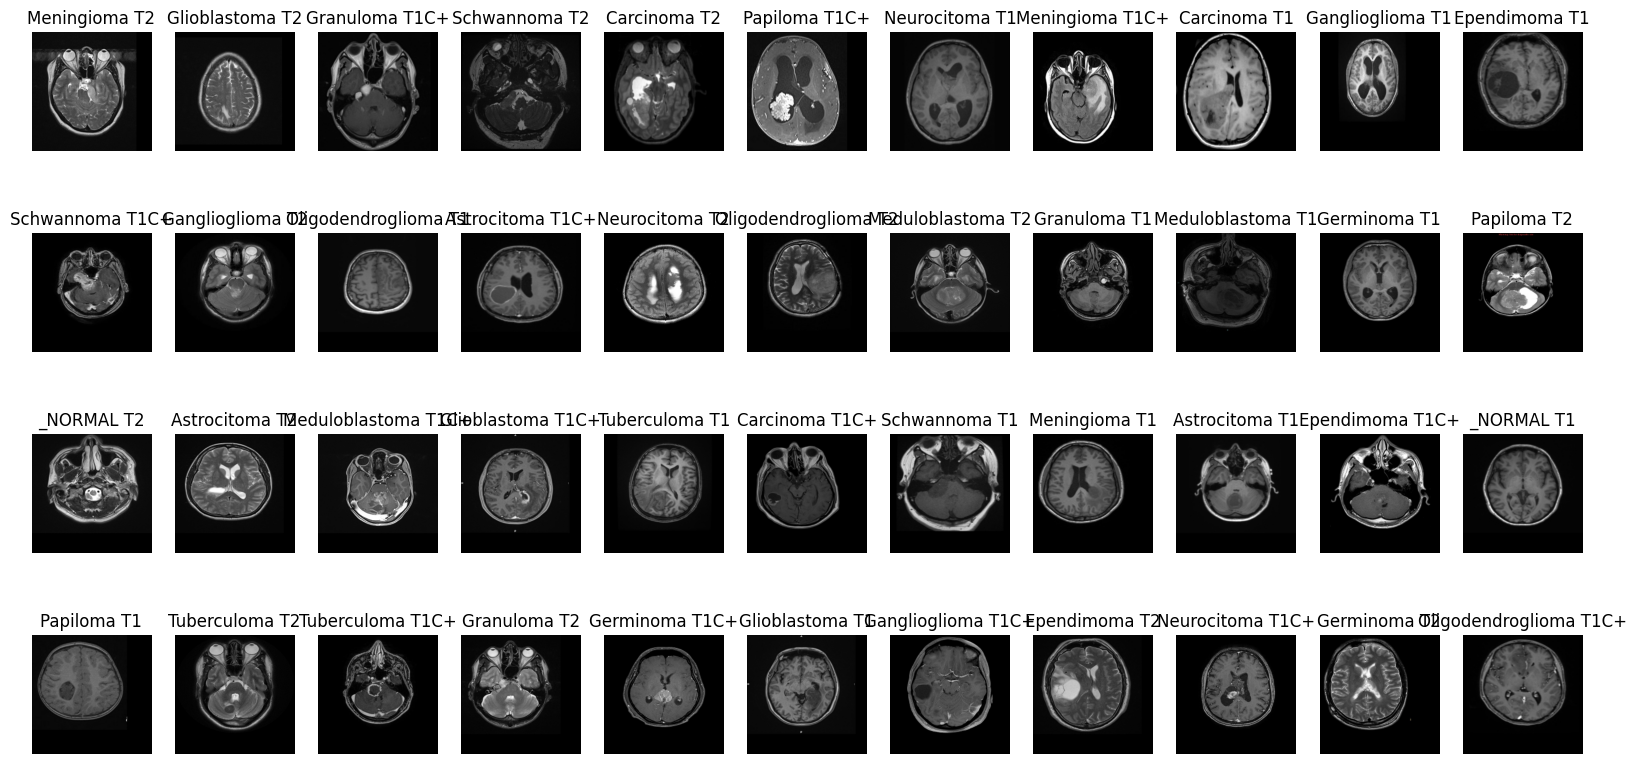

In [14]:
img_paths,label = img_path_load(os.path.join(Data_dir,"train"))
plt_show(img_paths,label,show_num)


In [15]:
works = os.cpu_count()
print(works)
batch_size = 32

2


In [16]:
# dataset 평균 표준편차 계산
def mean_std_dataset(train_ds):
  print(f"data_shape : {train_ds[0][0].numpy().shape}")
  meanRGB = [np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
  stdRGB = [np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

  mean_ds,std_ds = [],[]

  for i in range(3):
    mean_ds.append(np.mean([m[i] for m in meanRGB]))
    std_ds.append(np.mean([s[i] for s in stdRGB]))

  print("mean : ",mean_ds)
  print("std : ",std_ds)

  return mean_ds,std_ds

# 
def mean_std():
  default_transform = transforms.Compose([
    transforms.Resize(img_size),
    # 0~1 범위로 변환
    transforms.ToTensor()
    ])
  
  train_data = ImageFolder(os.path.join(Data_dir,"train"),default_transform)
  return mean_std_dataset(train_data)

def data_loader(dataset,batch_size,collate=None):
  return DataLoader(dataset,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = works,
                    collate_fn = collate
                    )



In [17]:
mean,std = mean_std()

data_shape : (3, 224, 224)
mean :  [0.18515638, 0.18515193, 0.18515205]
std :  [0.19320688, 0.19320653, 0.19320653]


In [18]:
# train data
def image_to_trainset(batch_size,val_size):
  start = time.time()

  transform = transforms.Compose([
      # image resize
      # transforms.Resize(img_size),
      # 0~1 범위로 변환
      transforms.ToTensor(),
      # ( Input(channel) - mean(channel) ) / std(channel)
      transforms.Normalize(mean,std)
  ])

  train_data = ImageFolder(os.path.join(Data_dir,"train"),transform)
  val_data = ImageFolder(os.path.join(Data_dir,"val"),transform)
  # train_data.transform = _transform

  train_num = len(train_data)
  indices = list(range(train_num))
  train_loader = data_loader(train_data,batch_size,collate=custom_collate)
  val_loader = data_loader(val_data,batch_size,collate=custom_collate)
  
  print(f"train_length : {len(train_data)} val_length : {len(val_data)}")
  print(f"Processing Time : {time.time()-start:.2f}s")
  return train_data,train_loader,val_loader

# test data
def image_to_testset(batch_size):
  transform = transforms.Compose([
      # transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize(mean,std)
  ])
  test_data = ImageFolder(os.path.join(Data_dir,"test"),transform)
  test_loader = data_loader(test_data,batch_size=batch_size,collate=custom_collate)
  
  return test_data,test_loader

In [19]:
train_data , train_loader, val_loader = image_to_trainset(batch_size,0.375)

test_data , test_loader = image_to_testset(batch_size)

print()

train_length : 2228 val_length : 1336
Processing Time : 0.02s



In [20]:
num_classes = len(train_data.classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [21]:
class network(nn.Module):
  def __init__(self):
    super(network,self).__init__()
    self.pre_train = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    print("output : ",self.pre_train.classifier)
    input_features_fc_layer = self.pre_train.classifier[1].out_features

    self.fcl = nn.Sequential(
        nn.BatchNorm1d(input_features_fc_layer),
        nn.Linear(input_features_fc_layer,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.Linear(512,num_classes)
    )
  
  def forward(self,x):
    x = self.pre_train(x)
    x = self.fcl(x)
    return x


In [22]:
# pre_trained
learning_rate = 1e-3
model = network().to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10,15],gamma=0.5)

params = list(model.parameters())
print(params[-1])

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 80.9MB/s]


output :  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Parameter containing:
tensor([-0.0071,  0.0441,  0.0376, -0.0366,  0.0116, -0.0010,  0.0225,  0.0239,
         0.0058,  0.0078, -0.0175, -0.0068,  0.0243,  0.0304, -0.0344, -0.0220,
        -0.0363, -0.0408,  0.0037, -0.0051,  0.0196, -0.0181,  0.0017, -0.0096,
        -0.0122, -0.0266,  0.0080, -0.0336, -0.0189, -0.0087,  0.0095, -0.0180,
        -0.0282, -0.0323,  0.0348, -0.0236,  0.0335,  0.0109,  0.0142,  0.0268,
        -0.0114,  0.0198,  0.0058, -0.0190], device='cuda:0',
       requires_grad=True)


In [23]:
train_size = len(train_loader.sampler)
val_size = len(val_loader.sampler)

In [64]:
def acc_count(predict,y):
  # 예상 y와 실제 y값 비교해 true값 count
  count = (predict.argmax(axis=1) == y).type(torch.float).sum().item()
  return count

# sec, ms 출력
def time_print(sec):
  print(f" - {sec:.0f}s {sec*1000%1000:.0f}ms/epoch")

def pg_bar(data_loader):
  return tqdm(data_loader,ncols=100)

In [25]:
def train(train_loader,val_loader,model,loss_fn,optimizer):
  start = time.time()

  batch_acc = 0
  batch_loss = 0
  data_size = 0

  train_bar = pg_bar(train_loader)
  for batch, (x, y) in enumerate(train_bar):
    x,y = x.to(device),y.to(device)
    it_size = len(x)
    predict = model(x)
    loss = loss_fn(predict, y)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # train_data의 batch 결과 저장
    batch_acc += acc_count(predict,y)
    batch_loss += loss.item() * it_size
    data_size += it_size

    train_acc = batch_acc/data_size
    train_loss = batch_loss/data_size

    train_bar.set_description(f"accuracy = {train_acc:.2%} - loss = {train_loss:.4f} ")
    
  train_bar.close()
  scheduler.step()
  
  val_acc = 0
  with torch.no_grad():
    val_loss = 0
    for x,y in val_loader:
      x,y = x.to(device),y.to(device)
      predict = model(x)
      # validation_data의 batch loss
      val_loss += loss_fn(predict,y).item() * len(x)
      val_acc += acc_count(predict,y)
    
    # validation loss 평균
    val_loss /= val_size
    val_acc /= val_size
    print(f" - val_accuracy: {val_acc:.2%} - val_loss: {val_loss:>.4f} - lr: {scheduler.get_last_lr()}",end="")
  
  time_print(time.time()-start)
  return train_acc,train_loss,val_acc,val_loss

In [70]:
def test(dataloader,model,loss_fn,classes=""):
  size = len(dataloader.dataset)
  print("test size : ", size)

  model.eval()
  test_loss = 0
  test_pred, test_label = [],[]
  with torch.no_grad():
    for x,y in pg_bar(dataloader):
      x,y = x.to(device),y.to(device)
      predict = model(x)
      test_loss += loss_fn(predict, y).item() * len(x)
      test_pred.extend(predict)
      test_label.extend(y)
  
  test_loss /= size
  test_pred,test_label = torch.stack(test_pred),torch.stack(test_label)
  test_acc = acc_count(test_pred,test_label) / size
  print(f"rep : {classification_report(test_pred.argmax(axis=1).cpu().numpy(),test_label.cpu().numpy())}")
  print(f"Test Error: \n Accuracy: {test_acc:>0.2%}, Avg loss: {test_loss:>4f} \n")


In [27]:
epochs = 25
metrics = ["train_acc","train_loss","val_acc","val_loss"]
hist = [[],[],[],[]]

In [28]:
for epoch in range(epochs):
  print(f"epoch : {epoch + 1}")
  train_acc,train_loss,val_acc,val_loss = train(train_loader,val_loader,model,loss,optimizer)
  hist[0].append(train_acc)
  hist[1].append(train_loss)
  hist[2].append(val_acc)
  hist[3].append(val_loss)
  

epoch : 1


accuracy = 38.87% - loss = 2.4170 : 100%|███████████████████████████| 70/70 [00:34<00:00,  2.02it/s]


 - val_accuracy: 55.31% - val_loss: 1.7139 - lr: [0.001] - 46s 356ms/epoch
epoch : 2


accuracy = 60.95% - loss = 1.4820 : 100%|███████████████████████████| 70/70 [00:26<00:00,  2.63it/s]


 - val_accuracy: 65.79% - val_loss: 1.2523 - lr: [0.001] - 38s 185ms/epoch
epoch : 3


accuracy = 71.95% - loss = 1.0305 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.54it/s]


 - val_accuracy: 70.66% - val_loss: 1.0739 - lr: [0.001] - 39s 932ms/epoch
epoch : 4


accuracy = 77.60% - loss = 0.7950 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.57it/s]


 - val_accuracy: 76.05% - val_loss: 0.9001 - lr: [0.001] - 40s 884ms/epoch
epoch : 5


accuracy = 80.57% - loss = 0.6786 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.57it/s]


 - val_accuracy: 76.12% - val_loss: 0.8996 - lr: [0.001] - 39s 888ms/epoch
epoch : 6


accuracy = 84.87% - loss = 0.5228 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.55it/s]


 - val_accuracy: 76.80% - val_loss: 0.8432 - lr: [0.001] - 39s 741ms/epoch
epoch : 7


accuracy = 86.45% - loss = 0.4797 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.57it/s]


 - val_accuracy: 80.16% - val_loss: 0.7317 - lr: [0.001] - 39s 125ms/epoch
epoch : 8


accuracy = 88.78% - loss = 0.3961 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.57it/s]


 - val_accuracy: 84.88% - val_loss: 0.5236 - lr: [0.001] - 39s 798ms/epoch
epoch : 9


accuracy = 92.68% - loss = 0.2605 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.55it/s]


 - val_accuracy: 86.30% - val_loss: 0.5035 - lr: [0.001] - 39s 169ms/epoch
epoch : 10


accuracy = 92.68% - loss = 0.2868 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.59it/s]


 - val_accuracy: 84.58% - val_loss: 0.5743 - lr: [0.0005] - 39s 71ms/epoch
epoch : 11


accuracy = 96.36% - loss = 0.1336 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.57it/s]


 - val_accuracy: 89.67% - val_loss: 0.3830 - lr: [0.0005] - 39s 823ms/epoch
epoch : 12


accuracy = 98.92% - loss = 0.0586 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.53it/s]


 - val_accuracy: 91.77% - val_loss: 0.3121 - lr: [0.0005] - 39s 317ms/epoch
epoch : 13


accuracy = 98.92% - loss = 0.0510 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.56it/s]


 - val_accuracy: 91.84% - val_loss: 0.3232 - lr: [0.0005] - 39s 199ms/epoch
epoch : 14


accuracy = 99.24% - loss = 0.0398 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.53it/s]


 - val_accuracy: 92.37% - val_loss: 0.3056 - lr: [0.0005] - 39s 958ms/epoch
epoch : 15


accuracy = 99.37% - loss = 0.0314 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.52it/s]


 - val_accuracy: 93.26% - val_loss: 0.2621 - lr: [0.00025] - 39s 778ms/epoch
epoch : 16


accuracy = 99.55% - loss = 0.0218 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.51it/s]


 - val_accuracy: 93.79% - val_loss: 0.2649 - lr: [0.00025] - 39s 82ms/epoch
epoch : 17


accuracy = 99.82% - loss = 0.0189 : 100%|███████████████████████████| 70/70 [00:28<00:00,  2.50it/s]


 - val_accuracy: 93.26% - val_loss: 0.2376 - lr: [0.00025] - 39s 593ms/epoch
epoch : 18


accuracy = 99.64% - loss = 0.0155 : 100%|███████████████████████████| 70/70 [00:28<00:00,  2.49it/s]


 - val_accuracy: 93.71% - val_loss: 0.2080 - lr: [0.00025] - 39s 714ms/epoch
epoch : 19


accuracy = 99.64% - loss = 0.0169 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.50it/s]


 - val_accuracy: 93.64% - val_loss: 0.2511 - lr: [0.00025] - 39s 243ms/epoch
epoch : 20


accuracy = 99.82% - loss = 0.0121 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.53it/s]


 - val_accuracy: 93.79% - val_loss: 0.2447 - lr: [0.00025] - 39s 12ms/epoch
epoch : 21


accuracy = 99.73% - loss = 0.0135 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.56it/s]


 - val_accuracy: 92.66% - val_loss: 0.2869 - lr: [0.00025] - 39s 563ms/epoch
epoch : 22


accuracy = 99.73% - loss = 0.0111 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.55it/s]


 - val_accuracy: 93.79% - val_loss: 0.2391 - lr: [0.00025] - 39s 538ms/epoch
epoch : 23


accuracy = 99.73% - loss = 0.0117 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.55it/s]


 - val_accuracy: 93.41% - val_loss: 0.2445 - lr: [0.00025] - 39s 766ms/epoch
epoch : 24


accuracy = 99.73% - loss = 0.0110 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.55it/s]


 - val_accuracy: 93.94% - val_loss: 0.2471 - lr: [0.00025] - 39s 918ms/epoch
epoch : 25


accuracy = 99.73% - loss = 0.0124 : 100%|███████████████████████████| 70/70 [00:27<00:00,  2.55it/s]


 - val_accuracy: 92.51% - val_loss: 0.2870 - lr: [0.00025] - 39s 68ms/epoch


In [71]:
y_pred = test(test_loader,model,loss)

test size :  915


100%|███████████████████████████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]

tensor([42, 27, 27, 11,  1, 35, 37, 25, 25, 42, 26, 32, 26, 23, 42, 24, 26, 22,
        31, 27,  2,  0, 34, 29, 25, 25, 29, 10,  4,  3,  4,  9, 24,  2, 43, 28,
        12, 37, 40, 37, 26,  2, 26, 37, 24, 14, 22, 25,  0, 43, 25, 42, 26, 33,
        37, 38,  5, 30, 14, 37, 28, 18, 16, 10, 17, 32, 20, 43, 42, 25, 26, 43,
        26, 28,  2,  1, 35,  5, 43, 41,  0,  2, 43, 11, 24, 42, 38, 28, 43,  2,
        37, 37, 41, 43, 38, 28,  5, 25, 18, 24, 26, 33, 36, 34, 19, 42, 28, 29,
        34, 24,  0,  1, 28, 31,  0, 25,  4, 38, 16, 42, 24, 43,  1, 43,  0, 31,
        31, 24, 16, 40,  3,  3, 26, 36, 28, 35, 24, 43, 18, 24, 38, 23, 34, 24,
        43, 42,  2,  1,  0, 25,  5, 42, 25, 39, 35, 43, 25,  1, 15, 33, 16, 36,
        36, 26, 34,  6, 12, 36,  3,  0, 24, 24, 25,  4, 30, 38, 43, 32, 25,  7,
        40, 25, 18, 28,  0,  5, 28, 30, 31, 40,  1, 38,  1, 24, 11, 32, 38,  5,
        37, 38, 29, 43, 26, 28, 25, 43, 27, 42, 16,  7, 43, 17, 31, 25,  2,  2,
         2,  0,  1, 37, 43,  1, 25, 31, 

In [73]:
torch.save(model.state_dict(),"model.pth")
print("save model")

save model


In [74]:
model = network()

model.load_state_dict(torch.load("model.pth"))
print("load model")

output :  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
load model


In [75]:
def draw_plot(history,line_style=["-","-."],color=["blue","red"]):
  plt.figure(figsize=(6,4))
  for i in range(4):
    plt.plot(history[i],c=color[i%2],label=metrics[i],alpha=0.5,linestyle=line_style[i//2])
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

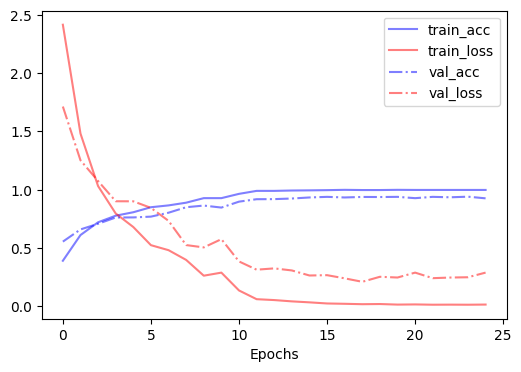

In [76]:
draw_plot(hist)